In [1]:
from InterOptimus.itworker import InterfaceWorker
from pymatgen.core.structure import Structure
from mp_api.client import MPRester
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer

In [2]:
with MPRester('fFtrdShVJH4jwWHiId8v4cyGzV2oYnoG') as mpr:
        docs = mpr.materials.summary.search(
        material_ids = ["mp-1153", "mp-362"],
        fields=["material_id", "structure", "nelements"])
        for doc in docs:
            material_id = doc.material_id
            structure = doc.structure
    
            # 使用 SpacegroupAnalyzer 获取常规结构
            analyzer = SpacegroupAnalyzer(structure)
            doc.structure = analyzer.get_conventional_standard_structure()
for i in docs:
    if i.material_id == "mp-1153":
        film_conv = i.structure
    else:
        substrate_conv = i.structure
iw = InterfaceWorker(film_conv, substrate_conv)

Retrieving SummaryDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

# Define InterfaceWorker

In [3]:
iw = InterfaceWorker(film_conv, substrate_conv)

# lattice matching

In [4]:
iw.lattice_matching(max_area = 20, max_length_tol = 0.03, max_angle_tol = 0.03,
                    film_max_miller = 1, substrate_max_miller = 1, film_millers = None, substrate_millers = None)
#Note max millers are in primitive cell, should be different from the indices in the polar projection below which are in conventional cell
#If you specify miller indices yourself, just ignore film_max_miller and substrate_max_miller

2


checking matching identity:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/jason/Documents/GitHub/InterOptimus/InterOptimus/matching.py:730: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


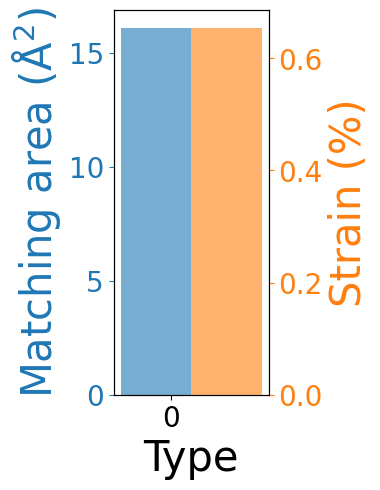

In [5]:
#Visualize matching information
iw.ems.plot_unique_matches()

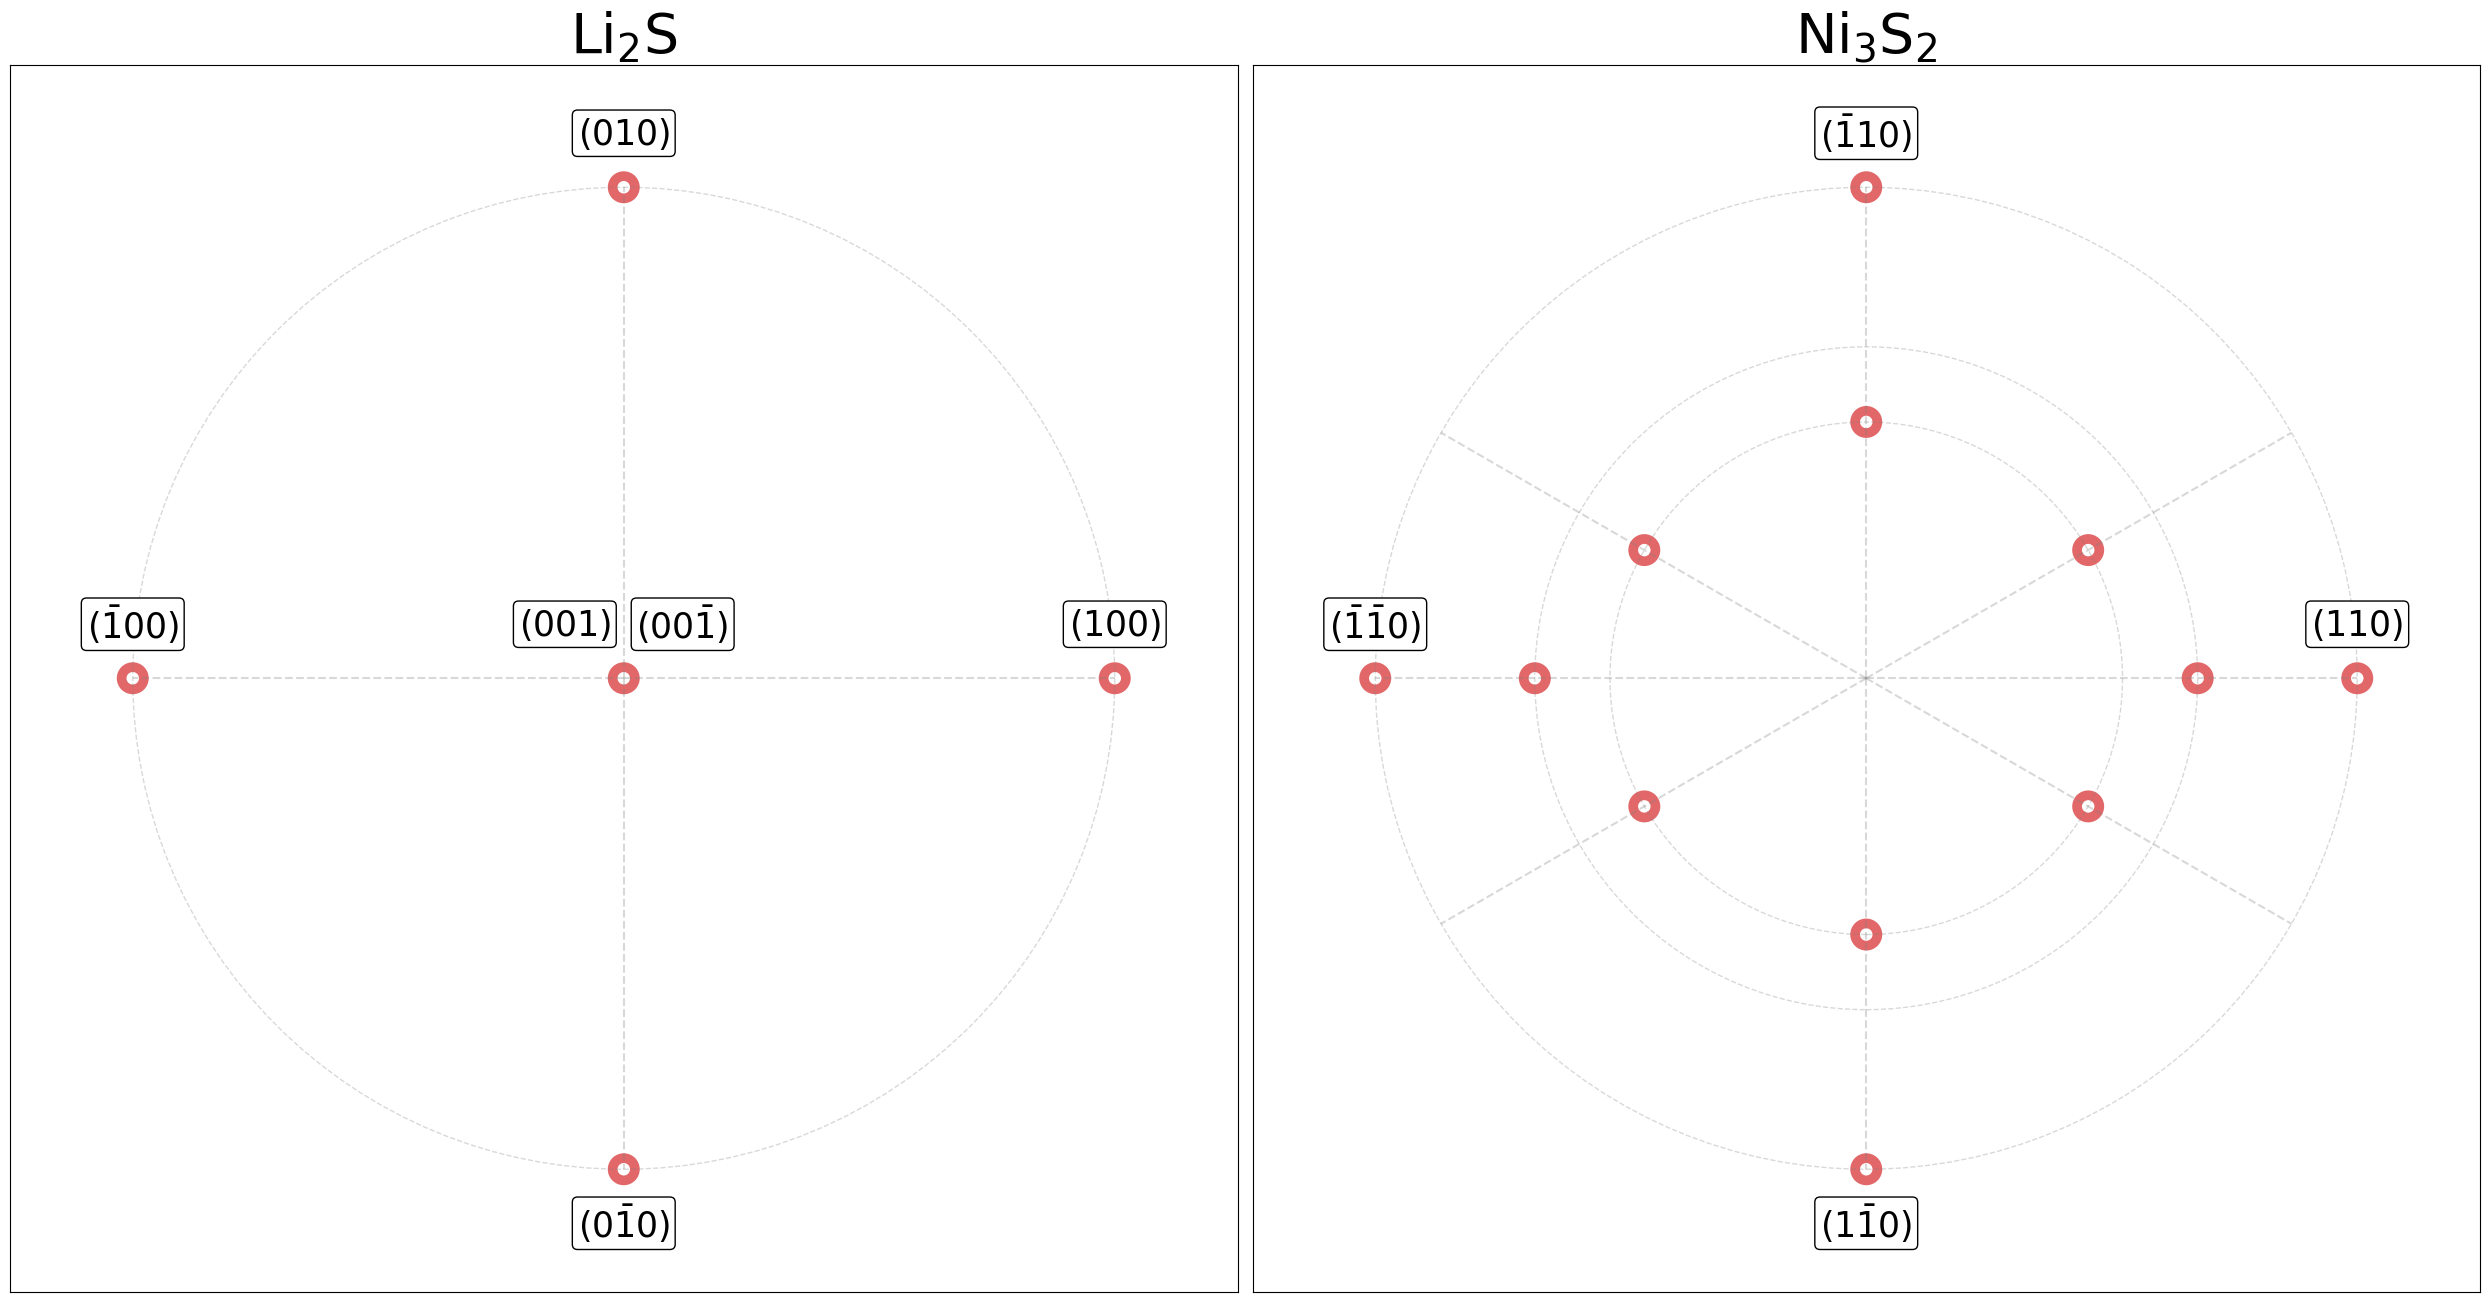

In [6]:
iw.ems.plot_matching_data(['Li$_2$S', 'Ni$_3$S$_2$'],'Ni3S2_Li2S_more.jpg', show_millers = True, show_legend = True)

# Define interface structural parameters 

For usage presentation, a large **termination_ftol** value is applied there.
However, for a small enough **termination_ftol** is necessary to find stable interface structures  

In [7]:
#These are defualt settings
iw.parse_interface_structure_params(termination_ftol = 0.2, c_periodic = False, \
                                    vacuum_over_film = 10, film_thickness = 15, \
                                    substrate_thickness = 15, shift_to_bottom = True)
#This will also screen out all the identical terminations

symmetry checking progress: 100%:  ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋

match 0: thicknesses (film, substrate) (17.01 16.12); num of unique terminations: 6


# Baysian Optimization by MLIP for Rigid Body Translation (RBT)

In [8]:
#define structure optimization conditions (optional). If not called, the non-optimized energy and structure will be used
iw.parse_optimization_params(do = True, 
                             set_fix_thicknesses = (1,1), 
                             fix_in_layers = True, 
                             whole_slab_fixed = True, 
                             fmax = 0.05, 
                             steps = 200, 
                             device = 'cpu', 
                             ckpt_path = 'orb-v3-conservative-20-omat-20250404.ckpt')

match 0: fix thicknesses (film, substrate) (2.84 4.03)


**do**: whether to apply structure optimization for the sampled structure with minimum non-optimized energy  
**set_fix_thicknesses**: (fixed film thickness, fixed substrate thickness)  
**fix_in_layers**: whether the fix thickness is in unit of layers  
**whole_slab_fixed**: whether to fix the whole slab to calculate its slab energy  
**fmax**: tolerance to stop structure optimization  
**steps**: maximum relaxing steps  
**device**: device to use for MLIP  
**ckpt_path**: path to store the check point, downloading if not set  

In [9]:
iw.global_minimization(n_calls = 10, 
                       z_range = (0.5, 3),
                       calc = 'orb-models', 
                       discut = 0.8, 
                       rank_by = 'bd', 
                       strain_E_correction = True)

/opt/anaconda3/envs/3.12/lib/python3.12/site-packages/orb_models/utils.py:30: UserWarning: Setting global torch default dtype to torch.float32.
  warnings.warn(f"Setting global torch default dtype to {torch_dtype}.")


matches:   0%|          | 0/1 [00:00<?, ?it/s]

unique terminations:   0%|          | 0/6 [00:00<?, ?it/s]

registration optimizing:   0%|          | 0/10 [00:00<?, ?it/s]

registration optimizing:   0%|          | 0/10 [00:00<?, ?it/s]

registration optimizing:   0%|          | 0/10 [00:00<?, ?it/s]

registration optimizing:   0%|          | 0/10 [00:00<?, ?it/s]

registration optimizing:   0%|          | 0/10 [00:00<?, ?it/s]

registration optimizing:   0%|          | 0/10 [00:00<?, ?it/s]

**n_calls**: number of bayesian optimization for each RBT optimizatio  
**z_range**: range of z coordinates for RBT optimization  
**calc**: energy calculator (only for orb-models and sevenn)  
**discut**: those with atoms closer than discut will have energy as 0 (ignore these structures)  
**rank_by**: the final interfaces will be ranked by 'bd' (binding energy) or 'it' (interface energy)  
**strain_E_correction**: whether the binding energy or interface energy is corrected considering film elastic energy by strain

In [10]:
iw.global_optimized_data

,$h_f$,$k_f$,$l_f$,$h_s$,$k_s$,$l_s$,$A$ (Å$^2$),$\epsilon$,$E_{it}$ $(J/m^2)$,$E_{bd}$ $(J/m^2)$,...,$w_{f2}$,$u_{s1}$,$v_{s1}$,$w_{s1}$,$u_{s2}$,$v_{s2}$,$w_{s2}$,$T$,$i_m$,$i_t$
2,-1,0,0,0,-1,1,16.076353,0.00654,0.597601,-3.164612,...,1/2,-1/3,1/3,1/3,2/3,1/3,1/3,"(1_S_P4/mmm_1, 3_Ni_P4/mmm_1)",0,2
4,-1,0,0,0,-1,1,16.076353,0.00654,1.461695,-2.296247,...,1/2,-1/3,1/3,1/3,2/3,1/3,1/3,"(2_Li_P4/mmm_2, 2_NiS_Pmm2_2)",0,4
5,-1,0,0,0,-1,1,16.076353,0.00654,1.528834,-2.234344,...,1/2,-1/3,1/3,1/3,2/3,1/3,1/3,"(2_Li_P4/mmm_2, 3_Ni_P4/mmm_1)",0,5
0,-1,0,0,0,-1,1,16.076353,0.00654,0.917746,-2.066074,...,1/2,-1/3,1/3,1/3,2/3,1/3,1/3,"(1_S_P4/mmm_1, 1_NiS_Pmm2_2)",0,0
1,-1,0,0,0,-1,1,16.076353,0.00654,1.873619,-1.883644,...,1/2,-1/3,1/3,1/3,2/3,1/3,1/3,"(1_S_P4/mmm_1, 2_NiS_Pmm2_2)",0,1
3,-1,0,0,0,-1,1,16.076353,0.00654,1.123794,-1.862947,...,1/2,-1/3,1/3,1/3,2/3,1/3,1/3,"(2_Li_P4/mmm_2, 1_NiS_Pmm2_2)",0,3


Definition of the interface energy $E_{it}$ and binding energy $E_{bd}$ see:  
doi:10.26434/chemrxiv-2024-hwthh

# Get the interface with lowest predicted energy by MLIP for each match

In [11]:
iw.global_optimized_data.to_csv('all_data.csv')

In [12]:
import shutil
import os
try:
    shutil.rmtree('all_its')
except:
    pass
os.mkdir('all_its')

In [15]:
#Output lowest-it-energy interfaces for each lattice matching type
ids = iw.global_optimized_data.index.to_numpy()
i_s = iw.global_optimized_data['$i_m$'].to_numpy()
j_s = iw.global_optimized_data['$i_t$'].to_numpy()

match_ids = []
pairs = []
for i in range(len(i_s)):
    if i_s[i] not in match_ids:
        match_ids.append(i_s[i])
        pairs.append((i_s[i], j_s[i]))

for i in range(len(ids)):
    iw.opt_results[(i_s[i],j_s[i])]['relaxed_best_interface']['structure'].to_file(f'all_its/{ids[i]}_POSCAR')

In [16]:
lowest_it_each_match = {}

In [17]:
try:
    shutil.rmtree('lowest_it_each_match')
except:
    pass
os.mkdir('lowest_it_each_match')

In [25]:
types = []
it_Es = []
bd_Es = []
for i in pairs:
    lowest_it_each_match[i[0]] = {}
    lowest_it_each_match[i[0]]['A'] = iw.opt_results[i]['A']
    lowest_it_each_match[i[0]]['it_E'] = iw.opt_results[i]['relaxed_min_it_E']
    lowest_it_each_match[i[0]]['bd_E'] = iw.opt_results[i]['relaxed_min_bd_E']
    types.append(i[0])
    it_Es.append(lowest_it_each_match[i[0]]['it_E'])
    bd_Es.append(lowest_it_each_match[i[0]]['bd_E'])
    iw.opt_results[i]['relaxed_best_interface']['structure'].to_file(f'lowest_it_each_match/{i[0]}_it_POSCAR')
    for j in ['stsg', 'stdb', 'fmsg', 'fmdb']:
        iw.opt_results[i]['slabs'][j]['structure'].to_file(f'lowest_it_each_match/{i[0]}_{j}_POSCAR')

In [26]:
import numpy as np

In [27]:
np.savetxt('it_bd_Es.dat',np.column_stack((types, it_Es, bd_Es)), fmt = '%i %.4f %.4f')